In [1]:
#Relevant packages and libraries

import numpy as np 
import pandas as pd 
from datetime import timedelta, date, time, datetime
import time 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read door_events CSV data file into DataFrame
door_events = pd.read_csv("door_events.csv",parse_dates=['timestamp_utc'])

# Read requests CSV test data file into DataFrame
requests = pd.read_csv("requests.csv",parse_dates=['pickup_timestamp_utc','dropoff_timestamp_utc'])


In [3]:
#Preview the data in a tabular form 

door_events.head()

,Unnamed: 0,vehicle_id,door_state,timestamp_utc,door_name
0,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger
1,1,vehicle_8d80,close,2020-02-12 05:44:29.130999430,passenger
2,2,vehicle_1e43,open,2020-02-12 11:22:15.486912267,passenger
3,3,vehicle_e136,closing,2020-02-12 22:02:13.275264985,passenger
4,4,vehicle_f653,open,2020-02-12 11:49:54.222489477,passenger


In [4]:
#Check datatype
door_events['timestamp_utc'].dtypes
requests['pickup_timestamp_utc'].dtypes

dtype('<M8[ns]')

In [5]:
requests.head()

,Unnamed: 0,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,vehicle_id,num_passengers
0,0,532d0e16-c098-4b,2020-02-12 22:47:34.456993103,2020-02-12 23:05:19.257940583,vehicle_8d80,2
1,1,6733c7b7-cd8d-4b,2020-02-13 01:24:45.285655499,2020-02-13 01:36:26.522647319,vehicle_cd00,2
2,2,12895eca-a8bb-41,2020-02-12 16:15:33.002158642,2020-02-12 16:21:24.103677982,vehicle_1e43,2
3,3,379588c2-a219-47,2020-02-13 01:53:04.029590845,2020-02-13 02:17:04.471062925,vehicle_e136,1
4,4,ad1fcd0c-ef5b-46,2020-02-12 05:58:21.626791000,2020-02-12 06:11:04.797907300,vehicle_42c0,1


Left join the data files "door_events" and "requests". The operation maps all the requests and door-events using vehicle ID-s as the common key. This results in multiple redundant rows with wrong maps which should be removed later. 

In [6]:
merged_left=pd.merge(door_events, requests, left_on="vehicle_id", right_on="vehicle_id")
merged_left.head()

,Unnamed: 0_x,vehicle_id,door_state,timestamp_utc,door_name,Unnamed: 0_y,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,num_passengers
0,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,5,603e4e31-a69b-40,2020-02-12 22:00:23.468418837,2020-02-12 22:08:32.482014477,2
1,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,9,32a6fb18-e8ed-40,2020-02-12 06:10:21.056766510,2020-02-12 06:28:34.774644990,1
2,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,17,9083b70a-8704-43,2020-02-12 09:06:18.687240601,2020-02-12 09:20:10.979255341,3
3,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,22,29c7b41f-88eb-41,2020-02-12 17:26:41.548894882,2020-02-12 17:43:27.666088042,2
4,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,25,0c99554e-479a-47,2020-02-12 23:55:18.648702383,2020-02-13 00:08:19.329434243,2


To map the correct request ID with vehicle ID-s, we create two new variables "pickup_duration(Mins.)" and "dropoff_duration(Mins.)" that correspond to the absolute differences calculated between the door-event timestamp of each row with the corresponding mapped pickup and dropoff timestamps respectively. The duration is calculated in minutes. We also create another column titled "travel_duration(Mins.), which is simply the absolute difference between the pickup and dropoff timestamps in minutes. 

In [7]:
#Calculate lags (in minutes) between pickup, dropoff, and door-events from timestamps
start_time = pd.to_datetime(merged_left['timestamp_utc'].astype(str)) 
end_pickup_time = pd.to_datetime(merged_left['pickup_timestamp_utc'].astype(str))
end_dropoff_time = pd.to_datetime(merged_left['dropoff_timestamp_utc'].astype(str))
merged_left['pickup_duration(Mins.)'] = abs(start_time.sub(end_pickup_time).dt.total_seconds().div(60))
merged_left['dropoff_duration(Mins.)'] = abs(start_time.sub(end_dropoff_time).dt.total_seconds().div(60))
merged_left['travel_duration(Mins.)'] = abs(end_dropoff_time.sub(end_pickup_time).dt.total_seconds().div(60))

In [8]:
merged_left.head()

,Unnamed: 0_x,vehicle_id,door_state,timestamp_utc,door_name,Unnamed: 0_y,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,num_passengers,pickup_duration(Mins.),dropoff_duration(Mins.),travel_duration(Mins.)
0,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,5,603e4e31-a69b-40,2020-02-12 22:00:23.468418837,2020-02-12 22:08:32.482014477,2,272.409935,280.560161,8.150227
1,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,9,32a6fb18-e8ed-40,2020-02-12 06:10:21.056766510,2020-02-12 06:28:34.774644990,1,677.630260,659.401628,18.228631
2,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,17,9083b70a-8704-43,2020-02-12 09:06:18.687240601,2020-02-12 09:20:10.979255341,3,501.669752,487.798218,13.871534
3,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,22,29c7b41f-88eb-41,2020-02-12 17:26:41.548894882,2020-02-12 17:43:27.666088042,2,1.288724,15.479896,16.768620
4,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,25,0c99554e-479a-47,2020-02-12 23:55:18.648702383,2020-02-13 00:08:19.329434243,2,387.329606,400.340952,13.011346


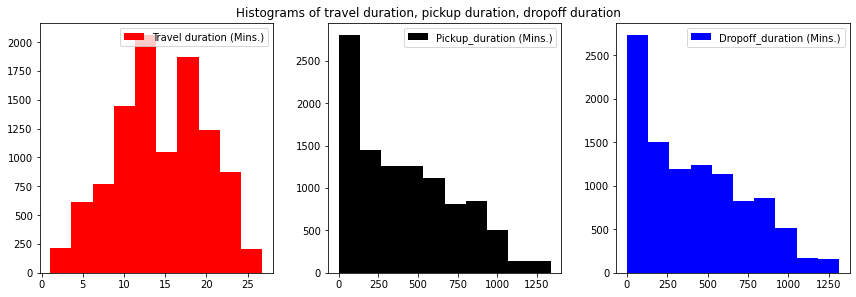

In [9]:
#f, axes = plt.subplots(1, 3, figsize=(5, 5), sharex=True)
#sns.histplot(data=merged_left, x="dropoff_duration(Mins.)")
#sns.histplot(data=merged_left, x="pickup_duration(Mins.)",ax=axes[0,0])
#sns.histplot(data=merged_left, x="dropoff_duration(Mins.)",ax=axes[0,0])
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(1, 3)
ttl1=fig.suptitle('Histograms of travel duration, pickup duration, dropoff duration')
ttl1.set_position([.5, 1.02])

merged_left['travel_duration(Mins.)'].hist(ax=axes[0],label='Travel duration (Mins.)', color="r")
merged_left['pickup_duration(Mins.)'].hist(ax=axes[1],label='Pickup_duration (Mins.)', color="k")
merged_left['dropoff_duration(Mins.)'].hist(ax=axes[2],label='Dropoff_duration (Mins.)', color = "b")
axes[0].grid(False)
axes[0].legend()
axes[1].grid(False)
axes[1].legend()
axes[2].grid(False)
axes[2].legend()

The travel duration is roughly bounded between 0-30 minutes. However, the histograms for pickup duration and dropoff durations clearly have anomalous values which are due to the wrong mappings. Hence, we must set a thresshold to identify correct pickup and dropoff durations. We define a parameter delta, which sets a cutoff for pickup and dropoff durations such that rows with pickup,dropoff durations > delta, shall not be considered for further calculations. 

In [10]:
#Setting pickup and dropoff duration cutoff
delta = 3

In [11]:
#dummy=merged_left[merged_left['vehicle_id'] == 'vehicle_65b1']
#dummy.head()
merged_left['req_id_pickup_true'] = np.where(merged_left['pickup_duration(Mins.)'] <= delta, 1, 0)
merged_left['req_id_dropoff_true'] = np.where(merged_left['dropoff_duration(Mins.)'] <= delta, 1, 0)
merged_left['door_opening_pickup']=np.where((merged_left['door_state'] == 'opening') & (merged_left['req_id_pickup_true'] == 1), 1, 0)
merged_left['door_open_pickup']=np.where((merged_left['door_state'] == 'open') & (merged_left['req_id_pickup_true'] == 1), 1, 0)
merged_left['door_closing_pickup']=np.where((merged_left['door_state'] == 'closing') & (merged_left['req_id_pickup_true'] == 1), 1, 0)
merged_left['door_close_pickup']=np.where((merged_left['door_state'] == 'close') & (merged_left['req_id_pickup_true'] == 1), 1, 0)
merged_left['door_opening_dropoff']=np.where((merged_left['door_state'] == 'opening') & (merged_left['req_id_dropoff_true'] == 1), 1, 0)
merged_left['door_open_dropoff']=np.where((merged_left['door_state'] == 'open') & (merged_left['req_id_dropoff_true'] == 1), 1, 0)
merged_left['door_closing_dropoff']=np.where((merged_left['door_state'] == 'closing') & (merged_left['req_id_dropoff_true'] == 1), 1, 0)
merged_left['door_close_dropoff']=np.where((merged_left['door_state'] == 'close') & (merged_left['req_id_dropoff_true'] == 1), 1, 0)



merged_left.head()

,Unnamed: 0_x,vehicle_id,door_state,timestamp_utc,door_name,Unnamed: 0_y,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,num_passengers,pickup_duration(Mins.),dropoff_duration(Mins.),travel_duration(Mins.),req_id_pickup_true,req_id_dropoff_true,door_opening_pickup,door_open_pickup,door_closing_pickup,door_close_pickup,door_opening_dropoff,door_open_dropoff,door_closing_dropoff,door_close_dropoff
0,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,5,603e4e31-a69b-40,2020-02-12 22:00:23.468418837,2020-02-12 22:08:32.482014477,2,272.409935,280.560161,8.150227,0,0,0,0,0,0,0,0,0,0
1,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,9,32a6fb18-e8ed-40,2020-02-12 06:10:21.056766510,2020-02-12 06:28:34.774644990,1,677.630260,659.401628,18.228631,0,0,0,0,0,0,0,0,0,0
2,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,17,9083b70a-8704-43,2020-02-12 09:06:18.687240601,2020-02-12 09:20:10.979255341,3,501.669752,487.798218,13.871534,0,0,0,0,0,0,0,0,0,0
3,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,22,29c7b41f-88eb-41,2020-02-12 17:26:41.548894882,2020-02-12 17:43:27.666088042,2,1.288724,15.479896,16.768620,1,0,0,0,0,1,0,0,0,0
4,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,25,0c99554e-479a-47,2020-02-12 23:55:18.648702383,2020-02-13 00:08:19.329434243,2,387.329606,400.340952,13.011346,0,0,0,0,0,0,0,0,0,0


From the "travel_duration" histogram, we notice that there are some values corresponding to travel times < 5 mins. Since these look too short to be feasible travel durations and might be tricky to map with a correct door event, we consider a parameter t_cutoff and only consider trips that have travel duration > t_cutoff. It might be of interest to vary t_cutoff and delta and analyse how the results change. 

In [12]:
#Setting thresshold for travel duration
t_cutoff=5

The datafile "merged_left" had been created by joining two datafiles "door_events" & "requests" to map the pickup and dropoff timestamps with the door events. It has dummy rows. A thresshold of 5 mins has been set to mark an event as a pickup or a dropoff. To remove the dummy rows, we create a new dataframe "valid_trips" below with a conditional statement of either "req_id_pickup_true" =1 or "req_id_dropoff_true=1" and "travel_duration(Mins.) > t_cutoff

In [13]:
valid_trips = merged_left[((merged_left['req_id_pickup_true'] == 1) | (merged_left['req_id_dropoff_true'] == 1)) & (merged_left['travel_duration(Mins.)'] > t_cutoff)]
#valid_trips[valid_trips.travel_duration > 1].shape[0]
valid_trips.head()


,Unnamed: 0_x,vehicle_id,door_state,timestamp_utc,door_name,Unnamed: 0_y,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,num_passengers,pickup_duration(Mins.),dropoff_duration(Mins.),travel_duration(Mins.),req_id_pickup_true,req_id_dropoff_true,door_opening_pickup,door_open_pickup,door_closing_pickup,door_close_pickup,door_opening_dropoff,door_open_dropoff,door_closing_dropoff,door_close_dropoff
3,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,22,29c7b41f-88eb-41,2020-02-12 17:26:41.548894882,2020-02-12 17:43:27.666088042,2,1.288724,15.479896,16.768620,1,0,0,0,0,1,0,0,0,0
5,0,vehicle_65b1,close,2020-02-12 17:27:58.872339574,passenger,38,564121ee-0371-47,2020-02-12 17:27:48.108626127,2020-02-12 17:41:42.010335807,2,0.179395,13.718967,13.898362,1,0,0,0,0,1,0,0,0,0
14,12,vehicle_65b1,opening,2020-02-12 22:08:49.469203305,passenger,5,603e4e31-a69b-40,2020-02-12 22:00:23.468418837,2020-02-12 22:08:32.482014477,2,8.433346,0.283120,8.150227,0,1,0,0,0,0,1,0,0,0
35,13,vehicle_65b1,close,2020-02-13 01:33:48.501167236,passenger,51,e9a22271-4389-4b,2020-02-13 01:15:58.205240965,2020-02-13 01:33:14.174141364,3,17.838265,0.572117,17.266148,0,1,0,0,0,0,0,0,0,1
54,16,vehicle_65b1,closing,2020-02-12 15:33:08.983038969,passenger,96,64958371-1b93-41,2020-02-12 15:22:19.686898470,2020-02-12 15:32:36.731035650,1,10.821602,0.537533,10.284069,0,1,0,0,0,0,0,0,1,0


In "valid_trips", note that there might be rows, where both "req_id_pickup_true" and "req_id_dropoff_true" are simultaneously 1 because it is possible that both variables "pickup_duration(Mins.)" and "dropoff_duration(Mins.)" satisy the thresshold conditions for delta, and hence might have been flagged as true variables. No simultaneous "True" flags in pickup and dropoff. 

In [14]:
dummy=valid_trips[(valid_trips['req_id_pickup_true'] == 1) & (valid_trips['req_id_dropoff_true'] == 1)]
dummy.head()

,Unnamed: 0_x,vehicle_id,door_state,timestamp_utc,door_name,Unnamed: 0_y,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,num_passengers,pickup_duration(Mins.),dropoff_duration(Mins.),travel_duration(Mins.),req_id_pickup_true,req_id_dropoff_true,door_opening_pickup,door_open_pickup,door_closing_pickup,door_close_pickup,door_opening_dropoff,door_open_dropoff,door_closing_dropoff,door_close_dropoff


In [15]:
valid_pickup = valid_trips[(valid_trips['req_id_pickup_true'] == 1)]
valid_dropoff = valid_trips[(valid_trips['req_id_dropoff_true'] == 1)]
#dummy = valid_pickup[(valid_pickup['pickup_duration(Mins.)'] < 5)]
#dummy.head()

In [16]:
pickup_open=valid_pickup[(valid_pickup['door_state'] == 'opening') | (valid_pickup['door_state'] == 'open') | (valid_pickup['door_state'] == 'closing') ]
dropoff_open=valid_dropoff[(valid_dropoff['door_state'] == 'opening') | (valid_dropoff['door_state'] == 'open') | (valid_dropoff['door_state'] == 'closing')]
dropoff_open.head()

,Unnamed: 0_x,vehicle_id,door_state,timestamp_utc,door_name,Unnamed: 0_y,req_id,pickup_timestamp_utc,dropoff_timestamp_utc,num_passengers,pickup_duration(Mins.),dropoff_duration(Mins.),travel_duration(Mins.),req_id_pickup_true,req_id_dropoff_true,door_opening_pickup,door_open_pickup,door_closing_pickup,door_close_pickup,door_opening_dropoff,door_open_dropoff,door_closing_dropoff,door_close_dropoff
14,12,vehicle_65b1,opening,2020-02-12 22:08:49.469203305,passenger,5,603e4e31-a69b-40,2020-02-12 22:00:23.468418837,2020-02-12 22:08:32.482014477,2,8.433346,0.283120,8.150227,0,1,0,0,0,0,1,0,0,0
54,16,vehicle_65b1,closing,2020-02-12 15:33:08.983038969,passenger,96,64958371-1b93-41,2020-02-12 15:22:19.686898470,2020-02-12 15:32:36.731035650,1,10.821602,0.537533,10.284069,0,1,0,0,0,0,0,0,1,0
82,29,vehicle_65b1,opening,2020-02-12 15:32:53.718224478,passenger,96,64958371-1b93-41,2020-02-12 15:22:19.686898470,2020-02-12 15:32:36.731035650,1,10.567189,0.283120,10.284069,0,1,0,0,0,0,1,0,0,0
97,38,vehicle_65b1,open,2020-02-12 15:56:43.716036874,passenger,99,6c9e010f-d2e2-4a,2020-02-12 15:45:41.596903086,2020-02-12 15:56:25.728848046,2,11.035319,0.299786,10.735532,0,1,0,0,0,0,0,1,0,0
105,45,vehicle_65b1,open,2020-02-13 01:33:32.161330192,passenger,51,e9a22271-4389-4b,2020-02-13 01:15:58.205240965,2020-02-13 01:33:14.174141364,3,17.565935,0.299786,17.266148,0,1,0,0,0,0,0,1,0,0


We sort the dataframes based on door states "opening,"open", and "closing". The corresponding pickup/dropoff durations represent the differences between the door event timestamps and the pickup/dropoff timestamps. 

In [17]:
df_pickup=pickup_open.groupby(['vehicle_id','req_id','num_passengers'])
df_dropoff=dropoff_open.groupby(['vehicle_id','req_id','num_passengers'])
df1 = df_pickup.agg(lambda x : tuple(sorted(x)))
df2 = df_dropoff.agg(lambda x : tuple(sorted(x)))
df1.head()

Unnamed: 0_x  ... door_close_dropoff
vehicle_id   req_id           num_passengers                   ...                   
vehicle_1e43 0a49c3fb-48e0-48 1               (205, 760, 840)  ...          (0, 0, 0)
             12895eca-a8bb-41 2                (66, 484, 520)  ...          (0, 0, 0)
             1b97d8a0-82e5-43 1                (31, 790, 868)  ...          (0, 0, 0)
             444e8ea5-cc11-4e 1                (84, 460, 919)  ...          (0, 0, 0)
             46138bb2-80f8-44 3               (108, 680, 911)  ...          (0, 0, 0)

[5 rows x 20 columns]

Function for calculating the mean value of elements of a tuple

In [18]:
def average(values):
     total = 0
     for element in values:
             total+=float(element)

     return total/len(values)

We calculate the peak and mean values of each tuple and add new columns "peak_open_pickup","mean_open_pickup","peak_open_dropoff","mean_open_dropoff" to the pickup and dropoff dataframes

In [19]:
list_pickup_peak=[]
list_pickup_mean=[]
list_dropoff_peak=[]
list_dropoff_mean=[]
for i in range(len(df1)) :
  list_pickup_peak.append((max(df1.iloc[i,7])))
  list_pickup_mean.append(average(df1.iloc[i,7]))
for i in range(len(df2)) :
  list_dropoff_peak.append((max(df2.iloc[i,8])))
  list_dropoff_mean.append(average(df2.iloc[i,8])) 

#print(list_pickup_mean)
#for i in range(len(df2)) :
#  list_dropoff.append((max(df2.iloc[i,9])))
#print(list_pickup)

df1['peak_open_pickup']=list_pickup_peak
df1['mean_open_pickup']=list_pickup_mean
df2['peak_open_dropoff']=list_dropoff_peak
df2['mean_open_dropoff']=list_dropoff_mean

#df2['open_duration_dropoff']=list_dropoff
df1.head()

Unnamed: 0_x  ... mean_open_pickup
vehicle_id   req_id           num_passengers                   ...                 
vehicle_1e43 0a49c3fb-48e0-48 1               (205, 760, 840)  ...         0.088993
             12895eca-a8bb-41 2                (66, 484, 520)  ...         0.166916
             1b97d8a0-82e5-43 1                (31, 790, 868)  ...         0.080907
             444e8ea5-cc11-4e 1                (84, 460, 919)  ...         0.105069
             46138bb2-80f8-44 3               (108, 680, 911)  ...         0.141729

[5 rows x 22 columns]

Plotting histograms for peak and mean durations for which the door remains open during each pickup and dropoff events

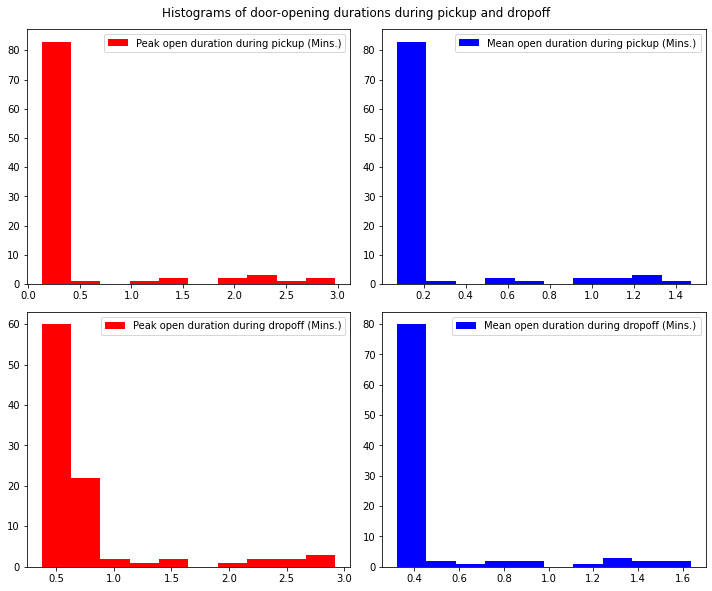

In [20]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["figure.autolayout"] = True

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ttl1=fig.suptitle('Histograms of door-opening durations during pickup and dropoff')
ttl1.set_position([.5, 1.02])

df1['peak_open_pickup'].hist(ax=ax1,label='Peak open duration during pickup (Mins.)', color="r")
df1['mean_open_pickup'].hist(ax=ax2,label='Mean open duration during pickup (Mins.)', color="b")
df2['peak_open_dropoff'].hist(ax=ax3,label='Peak open duration during dropoff (Mins.)', color="r")
df2['mean_open_dropoff'].hist(ax=ax4,label='Mean open duration during dropoff (Mins.)', color="b")
ax1.grid(False)
ax1.legend()
ax2.grid(False)
ax2.legend()
ax3.grid(False)
ax3.legend()
ax4.grid(False)
ax4.legend()


Comments: We note that the peak duration for which the vehicle door remains open during pickup events is peaked around 0.25 mins, while the mean duration is a little less ~ 0.15 mins. On the other hand, the peak and mean durations of doors remaining open during dropoff are higher ~0.5 mins. This might be due to several factors. Sometimes, there are confusions/delays with the payment methods. Also, the passengers often like to check with their belongings before they leave the vehicle. Such probable events result in an increased duration for which the vehicle door remains open.

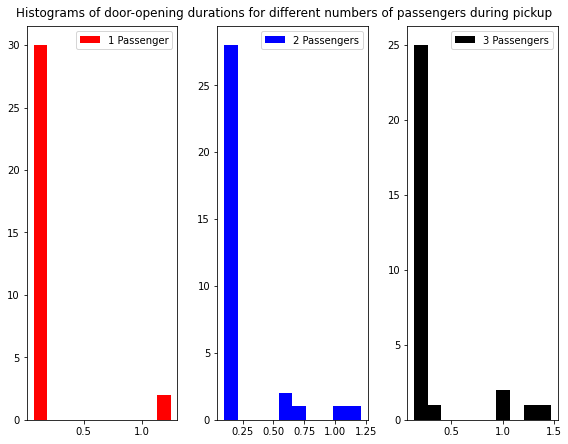

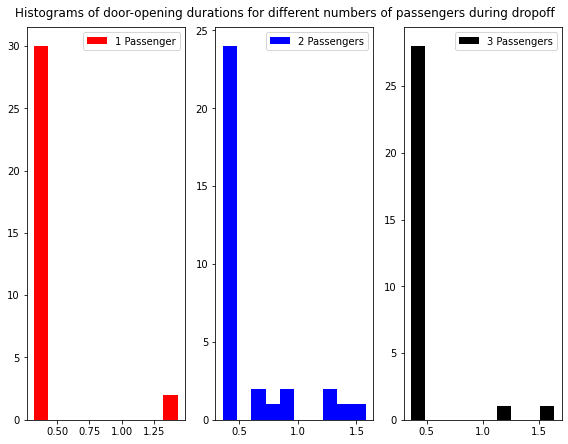

In [21]:
df1 = df1.reset_index('num_passengers')
df2 = df2.reset_index('num_passengers')
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

fig1, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
ttl1=fig1.suptitle('Histograms of door-opening durations for different numbers of passengers during pickup')
ttl1.set_position([.5, 1.02])

df1[df1['num_passengers'] == 1].mean_open_pickup.hist(ax=ax1,label='1 Passenger', color="r")
df1[df1['num_passengers'] == 2].mean_open_pickup.hist(ax=ax2,label='2 Passengers', color="b")
df1[df1['num_passengers'] == 3].mean_open_pickup.hist(ax=ax3,label='3 Passengers', color="k")
ax1.grid(False)
ax1.legend()
ax2.grid(False)
ax2.legend()
ax3.grid(False)
ax3.legend()

fig2, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
ttl2=fig2.suptitle('Histograms of door-opening durations for different numbers of passengers during dropoff')
ttl2.set_position([.5, 1.02])
df2[df2['num_passengers'] == 1].mean_open_dropoff.hist(ax=ax1,label='1 Passenger', color="r")
df2[df2['num_passengers'] == 2].mean_open_dropoff.hist(ax=ax2,label='2 Passengers', color="b")
df2[df2['num_passengers'] == 3].mean_open_dropoff.hist(ax=ax3,label='3 Passengers', color="k")
ax1.grid(False)
ax1.legend()
ax2.grid(False)
ax2.legend()
ax3.grid(False)
ax3.legend()
#ax4.grid(False)
#ax4.legend()
#ax5.grid(False)
#ax5.legend()
#ax6.grid(False)
#ax6.legend()

#df1[df1['peak_open_pickup'].hist(ax=ax1,label='Peak open duration during pickup (Mins.)', color="r")
#df1['mean_open_pickup'].hist(ax=ax2,label='Mean open duration during pickup (Mins.)', color="b")
#df2['peak_open_dropoff'].hist(ax=ax3,label='Peak open duration during dropoff (Mins.)', color="r")
#df2['mean_open_dropoff'].hist(ax=ax4,label='Mean open duration during dropoff (Mins.)', color="b")
#ax1.grid(False)
#ax1.legend()
#ax2.grid(False)
#ax2.legend()
#ax3.grid(False)
#ax3.legend()
#ax4.grid(False)
#ax4.legend()


Histograms of door opening durations during pickup and dropoff, plotted for different number of passengers taking the ride. While the peaks of the histograms for pickup and dropoff remain centred around 0.25 and 0.5 mins respectively (as seen in the earlier histograms), we notice that with higher number of passengers, the probabilities of having longer durations of door opening increase. With data for more vehicles, this effect is expected to become clearer. 

Mean values of door-open durations during pickup and dropoff. The mean value increases while dropoff, as supported by the histograms above. 

In [22]:
mean_pickup=df1['mean_open_pickup'].mean()
mean_dropoff=df2['mean_open_dropoff'].mean()

print(mean_pickup),print(mean_dropoff)

0.23345637357071922
0.4912581535998657


(None, None)

We find that the mean duration of doors remaining opened increases with number of passengers. However, for dropoff, we observe that the mean value for 3 passengers is less than that for 2 passengers. This might be due to insufficient data. 

In [23]:
a=df1.groupby("num_passengers").agg({"peak_open_pickup" : np.mean})
b=df2.groupby("num_passengers").agg({"peak_open_dropoff" : np.mean})
print(a),print(b)

                peak_open_pickup
num_passengers                  
1                       0.287688
2                       0.406979
3                       0.545278
                peak_open_dropoff
num_passengers                   
1                        0.605592
2                        0.917991
3                        0.773670


(None, None)